In [1]:
import os
os.environ["KAGGLEHUB_CACHE"] = "data"

import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
from torch import Tensor
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from safetensors.torch import save_file
from pathlib import Path
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.backends.cuda.is_available() else 'cpu'
torch.set_default_device(device)
torch.manual_seed(0)
torch.mps.manual_seed(0)

In [2]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "uciml/iris",
  "Iris.csv",
)

df.drop('Id', axis=1, inplace=True)
le = LabelEncoder()
df['Species_encoded'] = le.fit_transform(df["Species"])
df.iloc[[0, 50, 100], :]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
0,5.1,3.5,1.4,0.2,Iris-setosa,0
50,7.0,3.2,4.7,1.4,Iris-versicolor,1
100,6.3,3.3,6.0,2.5,Iris-virginica,2


In [3]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

<Axes: >

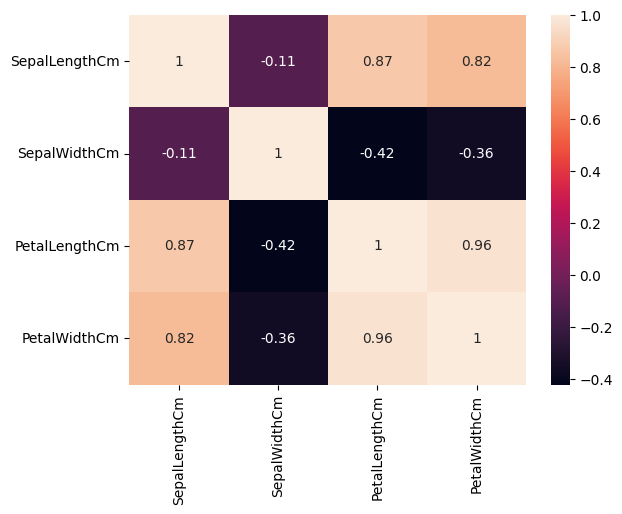

In [4]:
sns.heatmap(X.corr(), annot=True)

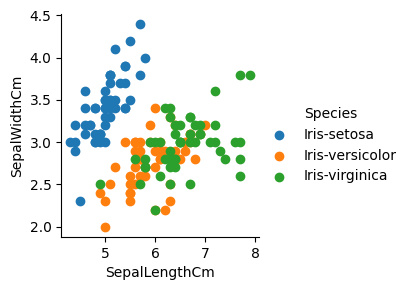

In [5]:
sns.FacetGrid(df, hue='Species').map(plt.scatter, "SepalLengthCm", "SepalWidthCm").add_legend()

In [6]:
Xt = torch.tensor(X.values, dtype=torch.float32, device=device)
yt = torch.tensor(y.values, dtype=torch.float32, device=device)
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.8)
del Xt, yt

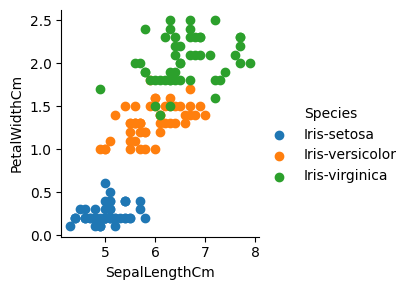

In [7]:
sns.FacetGrid(df, hue='Species').map(plt.scatter, "SepalLengthCm", "PetalWidthCm").add_legend()

In [8]:
import torch
from torch import Tensor
from torch.nn import Module, Sequential, Linear, ReLU

class IrisDeepLearning(Module):
    def __init__(self):
        super().__init__()
        self.layer = Sequential(
            Linear(in_features=4, out_features=3),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layer(x)

model = IrisDeepLearning()
optimizer = SGD(params=model.parameters(), lr=1e-3)

In [9]:
loss_fun = CrossEntropyLoss()

In [10]:
epochs = 1 + 40000

epoch_all = []
loss_all = []
test_loss_all = []
model.train()
for epoch in range(epochs):
    y_logits = model(X_train)

    loss = loss_fun(y_logits, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % int(epochs / 10) == 0:
        acc = accuracy_score(y_train.cpu(), y_logits.argmax(dim=1).cpu())
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            loss_test = loss_fun(test_logits, y_test)
            test_loss_all.append(loss_test.item())
            test_acc = accuracy_score(y_test.cpu(), test_logits.argmax(dim=1).cpu())

        epoch_all.append(epoch)
        loss_all.append(loss.item())
        print(f"epoch {epoch}, loss {loss:.5f}, acc {acc:.5f}, test loss {loss_test:.5f}, test acc {test_acc:.5f}")

print('Done')

epoch 0, loss 1.58286, acc 0.39167, test loss 2.15416, test acc 0.10000
epoch 4000, loss 0.50116, acc 0.87500, test loss 0.43735, test acc 0.90000
epoch 8000, loss 0.40503, acc 0.94167, test loss 0.33950, test acc 0.93333
epoch 12000, loss 0.35213, acc 0.95833, test loss 0.28748, test acc 0.96667
epoch 16000, loss 0.31520, acc 0.95833, test loss 0.25159, test acc 0.96667
epoch 20000, loss 0.28729, acc 0.96667, test loss 0.22466, test acc 0.96667
epoch 24000, loss 0.26529, acc 0.96667, test loss 0.20357, test acc 0.96667
epoch 28000, loss 0.24747, acc 0.96667, test loss 0.18657, test acc 0.96667
epoch 32000, loss 0.23273, acc 0.96667, test loss 0.17259, test acc 0.96667
epoch 36000, loss 0.22031, acc 0.96667, test loss 0.16088, test acc 0.96667
epoch 40000, loss 0.20971, acc 0.96667, test loss 0.15094, test acc 0.96667
Done


fina: loss 0.20971, acc 0.96667, test loss 0.15094, test acc 0.96667


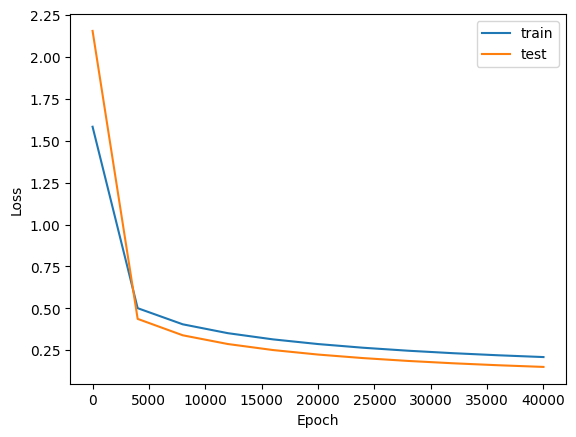

In [11]:
print(f"fina: loss {loss:.5f}, acc {acc:.5f}, test loss {loss_test:.5f}, test acc {test_acc:.5f}")
plt.plot(epoch_all, loss_all, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_all, test_loss_all, label="test")
plt.legend()

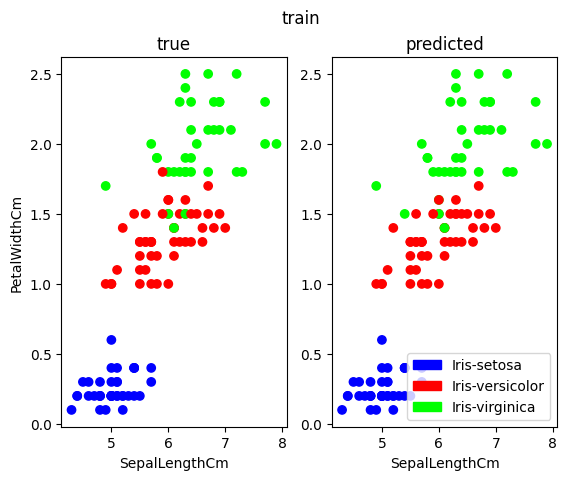

In [12]:
cmap = 'brg'
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 3].cpu(), c=y_train.cpu(), cmap=cmap)
plt.xlabel("SepalLengthCm")
plt.ylabel("PetalWidthCm")
plt.title('true')
plt.suptitle('train')

model.eval()
with torch.inference_mode():
    y_logits = model(X_train)
plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0].cpu(), X_train[:, 3].cpu(), c=y_logits.argmax(dim=1).cpu(), cmap=cmap)
plt.xlabel("SepalLengthCm")
plt.title('predicted')

cmap = plt.get_cmap(cmap)
classes = range(len(le.classes_))
legend_handles = [
    Patch(color=cmap(cls / max(classes)), label=le.classes_[cls])
    for cls in classes
]
plt.legend(handles=legend_handles)

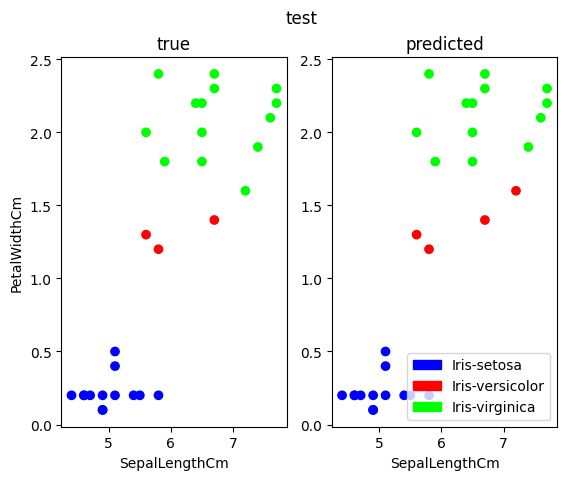

In [13]:
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 3].cpu(), c=y_test.cpu(), cmap=cmap)
plt.xlabel("SepalLengthCm")
plt.ylabel("PetalWidthCm")
plt.title('true')
plt.suptitle('test')

model.eval()
with torch.inference_mode():
    test_logits = model(X_test)
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 3].cpu(), c=test_logits.argmax(dim=1).cpu(), cmap=cmap)
plt.xlabel("SepalLengthCm")
plt.title('predicted')

cmap = plt.get_cmap(cmap)
classes = range(len(le.classes_))
legend_handles = [
    Patch(color=cmap(cls / max(classes)), label=le.classes_[cls])
    for cls in classes
]
plt.legend(handles=legend_handles)

In [14]:
model.eval()
with torch.inference_mode():
    i = 15
    y_logits = model.forward(X_test[i, :])
    print(f"predict: {y_logits.argmax()}, true: {y_test[i].item()}")

predict: 2, true: 2.0


In [15]:
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)
model_path = model_dir / Path("model.safetensors")

In [16]:
save_file(model.state_dict(), filename=model_path)